# Merton Model: Iterative Algorithm for $\sigma_V$ and $V_t$

## Setup

The Merton model links **observable equity values** $S_t$ to the **latent asset value process** $V_t$ via the Black-Scholes formula:

$$S_t = V_t \Phi(d_{t,1}) - B e^{-r(T-t)} \Phi(d_{t,2})$$

where:
$$d_{t,1} = \frac{\log(V_t/B) + (r + \frac{1}{2}\sigma_V^2)(T-t)}{\sigma_V \sqrt{T-t}}, \quad d_{t,2} = d_{t,1} - \sigma_V\sqrt{T-t}$$

**Problem:** We observe $S_t$ daily, but $V_t$ and $\sigma_V$ are both unknown. The iterative algorithm solves this jointly.

### Algorithm
1. Initialize $\sigma_V^{(0)}$ (e.g. from equity volatility scaled by leverage)
2. At each step $k$: invert the BS formula to get $V_t^{(k)}$ for all $t$ given $\sigma_V^{(k)}$
3. Compute updated $\sigma_V^{(k+1)}$ as sample std of log-returns on $\{V_t^{(k)}\}$
4. Repeat until $|\sigma_V^{(k+1)} - \sigma_V^{(k)}| < \epsilon$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.optimize import fsolve

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
print('Libraries loaded.')

Libraries loaded.


## Step 1: Simulate Ground Truth

We simulate a true asset value process $V_t$ under GBM, then compute observable equity prices $S_t$ from the BS formula. This gives us a controlled setting where we know the true $\sigma_V$ and can evaluate convergence.

In [2]:
# ─── True parameters (ground truth) ───────────────────────────────────────────
V0_true   = 1612.0   # Initial asset value (RadioShack example from lecture)
sigma_V_true = 0.26  # True asset volatility
mu_V      = 0.05     # Physical drift
B         = 1042.0   # Default threshold (face value of debt)
r         = 0.02     # Risk-free rate
T         = 1.0      # Time to maturity (1 year horizon)
n_days    = 550      # ~2.2 years of daily data
dt        = 1/252    # Daily steps

# ─── Simulate GBM asset path ──────────────────────────────────────────────────
Z = np.random.standard_normal(n_days)
log_returns = (mu_V - 0.5 * sigma_V_true**2) * dt + sigma_V_true * np.sqrt(dt) * Z
V_path = V0_true * np.exp(np.cumsum(log_returns))
V_path = np.insert(V_path, 0, V0_true)  # prepend V_0

print(f'Asset path simulated: {len(V_path)} observations')
print(f'V_0 = {V_path[0]:.1f}, V_T = {V_path[-1]:.1f}')

Asset path simulated: 551 observations
V_0 = 1612.0, V_T = 1429.1


## Step 2: Generate Observable Equity Prices

At each time $t$, remaining time to maturity is $T - t$. We compute $S_t$ from the Black-Scholes call formula applied to $V_t$.

In [3]:
def bs_call(V, B, r, sigma, tau):
    """Black-Scholes call price. Returns equity value S_t."""
    if tau <= 0:
        return max(V - B, 0.0)
    d1 = (np.log(V / B) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return V * norm.cdf(d1) - B * np.exp(-r * tau) * norm.cdf(d2)

def bs_d1_d2(V, B, r, sigma, tau):
    d1 = (np.log(V / B) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return d1, d2

# Generate equity prices from true asset path
times = np.arange(n_days + 1) * dt          # time elapsed
taus  = np.maximum(T - times, 1e-6)          # remaining time to maturity

S_observed = np.array([
    bs_call(V_path[i], B, r, sigma_V_true, taus[i])
    for i in range(len(V_path))
])

print(f'Equity price range: [{S_observed.min():.1f}, {S_observed.max():.1f}]')
print(f'Note: equity = 0 would signal default region (V < B={B})')

Equity price range: [284.0, 1098.7]
Note: equity = 0 would signal default region (V < B=1042.0)


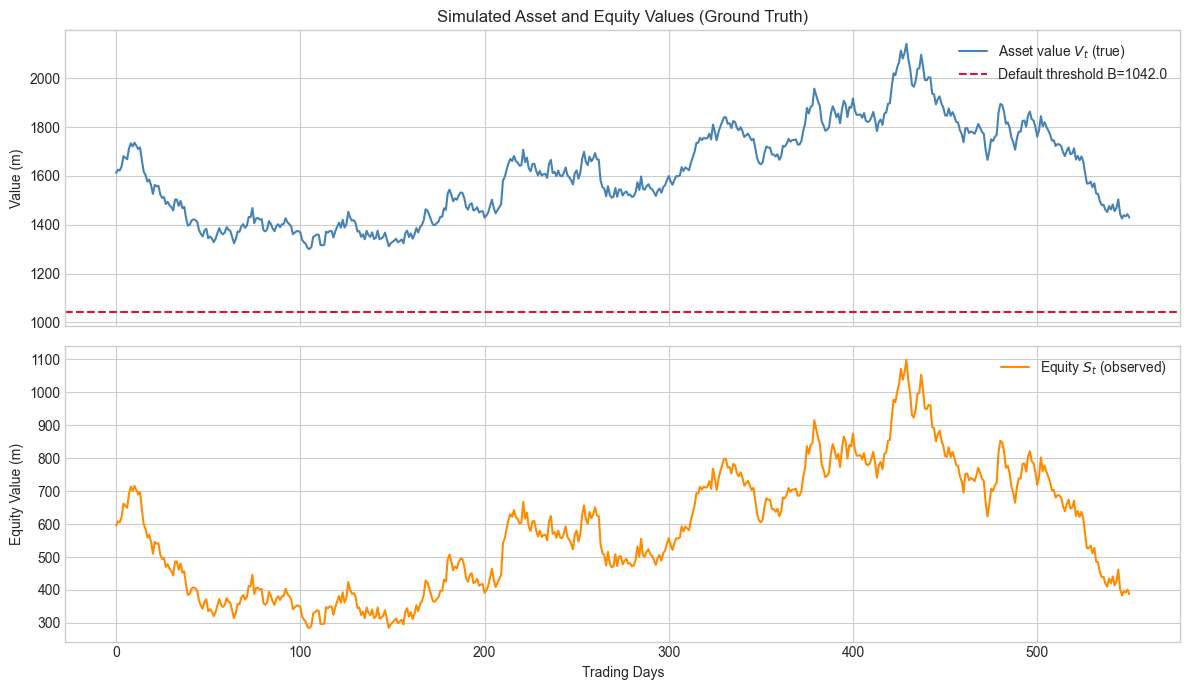

Figure saved.


In [4]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

axes[0].plot(times * 252, V_path, color='steelblue', lw=1.5, label='Asset value $V_t$ (true)')
axes[0].axhline(B, color='crimson', ls='--', lw=1.5, label=f'Default threshold B={B}')
axes[0].set_ylabel('Value (m)')
axes[0].set_title('Simulated Asset and Equity Values (Ground Truth)')
axes[0].legend()

axes[1].plot(times * 252, S_observed, color='darkorange', lw=1.5, label='Equity $S_t$ (observed)')
axes[1].set_ylabel('Equity Value (m)')
axes[1].set_xlabel('Trading Days')
axes[1].legend()

plt.tight_layout()
plt.savefig('01_true_paths.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure saved.')

## Step 3: The Iterative Algorithm

Now we **pretend we don't know** $V_t$ or $\sigma_V$. We only observe $\{S_t\}$, $B$, $r$, and $T$.

### Inverting the BS formula for $V_t$

Given $\sigma_V^{(k)}$, we solve for $V_t$ numerically at each $t$:
$$S_t = \text{BS}(V_t; B, r, \sigma_V^{(k)}, \tau_t)$$

This is a monotone function in $V_t \in (0, \infty)$, so root-finding (Brent's method) works reliably.

In [5]:
def invert_bs(S_obs, B, r, sigma, tau, tol=1e-8):
    """
    Given observed equity S, solve for asset value V such that:
        BS_call(V; B, r, sigma, tau) = S
    Uses Brent's method on a bracketed interval.
    """
    if tau <= 0:
        return S_obs + B  # at maturity: S = max(V-B, 0) => V = S + B
    
    # Lower bound: V >= S (equity can't exceed asset value)
    # Upper bound: V = S + B*e^{-r*tau} is a generous upper bound
    V_lo = max(S_obs, 1e-4)
    V_hi = S_obs + B * np.exp(-r * tau) * 10  # overshoot for safety
    
    f = lambda V: bs_call(V, B, r, sigma, tau) - S_obs
    
    try:
        V_sol = brentq(f, V_lo, V_hi, xtol=tol)
    except ValueError:
        # Fallback: expand bracket
        V_hi *= 100
        V_sol = brentq(f, V_lo, V_hi, xtol=tol)
    
    return V_sol


def run_iteration(S_observed, taus, B, r, sigma_init, max_iter=200, tol=1e-6, verbose=True):
    """
    Iterative algorithm to jointly estimate sigma_V and {V_t}.
    
    Parameters
    ----------
    S_observed : array of observed equity prices
    taus       : array of remaining maturities at each date
    B          : default threshold
    r          : risk-free rate
    sigma_init : initial guess for sigma_V
    
    Returns
    -------
    sigma_history : sigma_V at each iteration
    V_final       : recovered asset values at convergence
    """
    sigma = sigma_init
    sigma_history = [sigma]
    
    for k in range(max_iter):
        # Step 1: Invert BS to recover V_t for each t
        V_recovered = np.array([
            invert_bs(S_observed[i], B, r, sigma, taus[i])
            for i in range(len(S_observed))
        ])
        
        # Step 2: Compute log-returns on recovered asset values
        log_ret = np.diff(np.log(V_recovered))
        
        # Step 3: Update sigma_V as annualized sample std
        sigma_new = np.std(log_ret, ddof=1) * np.sqrt(252)
        
        delta = abs(sigma_new - sigma)
        sigma_history.append(sigma_new)
        
        if verbose and (k < 5 or k % 10 == 0):
            print(f'  Iter {k+1:3d}: sigma_V = {sigma_new:.6f}  |  delta = {delta:.2e}')
        
        sigma = sigma_new
        
        if delta < tol:
            if verbose:
                print(f'  >>> Converged at iteration {k+1} (delta={delta:.2e})')
            break
    
    return np.array(sigma_history), V_recovered

print('Functions defined. Ready to run iteration.')

Functions defined. Ready to run iteration.


In [6]:
# ─── Initial guess: equity volatility scaled by S/V ratio (naive leverage adj) ─
equity_log_ret = np.diff(np.log(S_observed + 1e-8))
sigma_equity   = np.std(equity_log_ret, ddof=1) * np.sqrt(252)
leverage_proxy = np.mean(S_observed) / np.mean(S_observed + B)
sigma_init     = sigma_equity * leverage_proxy

print(f'Equity volatility (observed): {sigma_equity:.4f}')
print(f'Leverage proxy S/(S+B):       {leverage_proxy:.4f}')
print(f'Initial sigma_V guess:         {sigma_init:.4f}')
print(f'True sigma_V:                  {sigma_V_true:.4f}')
print()

sigma_history, V_recovered = run_iteration(
    S_observed, taus, B, r,
    sigma_init=sigma_init,
    max_iter=200,
    tol=1e-7,
    verbose=True
)

sigma_final = sigma_history[-1]
print(f'\nFinal estimated sigma_V: {sigma_final:.4f}')
print(f'True sigma_V:            {sigma_V_true:.4f}')
print(f'Error:                   {abs(sigma_final - sigma_V_true):.4f}')

Equity volatility (observed): 0.7440
Leverage proxy S/(S+B):       0.3571
Initial sigma_V guess:         0.2657
True sigma_V:                  0.2600

  Iter   1: sigma_V = 0.254244  |  delta = 1.14e-02
  Iter   2: sigma_V = 0.253623  |  delta = 6.21e-04
  Iter   3: sigma_V = 0.253591  |  delta = 3.27e-05
  Iter   4: sigma_V = 0.253589  |  delta = 1.71e-06
  Iter   5: sigma_V = 0.253589  |  delta = 8.99e-08
  >>> Converged at iteration 5 (delta=8.99e-08)

Final estimated sigma_V: 0.2536
True sigma_V:            0.2600
Error:                   0.0064


## Step 4: Convergence Diagnostics

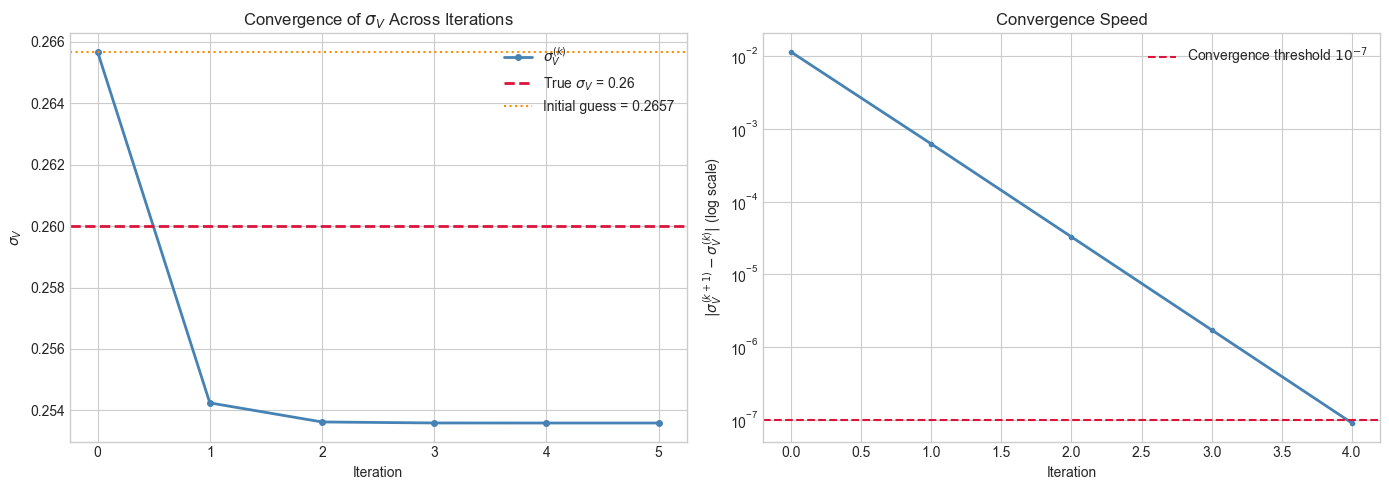

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ─── Convergence path ──────────────────────────────────────────────────────────
axes[0].plot(sigma_history, marker='o', markersize=4, color='steelblue', lw=2, label='$\\sigma_V^{(k)}$')
axes[0].axhline(sigma_V_true, color='crimson', ls='--', lw=2, label=f'True $\\sigma_V$ = {sigma_V_true}')
axes[0].axhline(sigma_init, color='darkorange', ls=':', lw=1.5, label=f'Initial guess = {sigma_init:.4f}')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('$\\sigma_V$')
axes[0].set_title('Convergence of $\\sigma_V$ Across Iterations')
axes[0].legend()

# ─── Delta (change in sigma per iteration) ─────────────────────────────────────
deltas = np.abs(np.diff(sigma_history))
axes[1].semilogy(deltas, color='steelblue', lw=2, marker='o', markersize=3)
axes[1].axhline(1e-7, color='crimson', ls='--', label='Convergence threshold $10^{-7}$')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('$|\\sigma_V^{(k+1)} - \\sigma_V^{(k)}|$ (log scale)')
axes[1].set_title('Convergence Speed')
axes[1].legend()

plt.tight_layout()
plt.savefig('02_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

## Step 5: Recovered Asset Values vs True

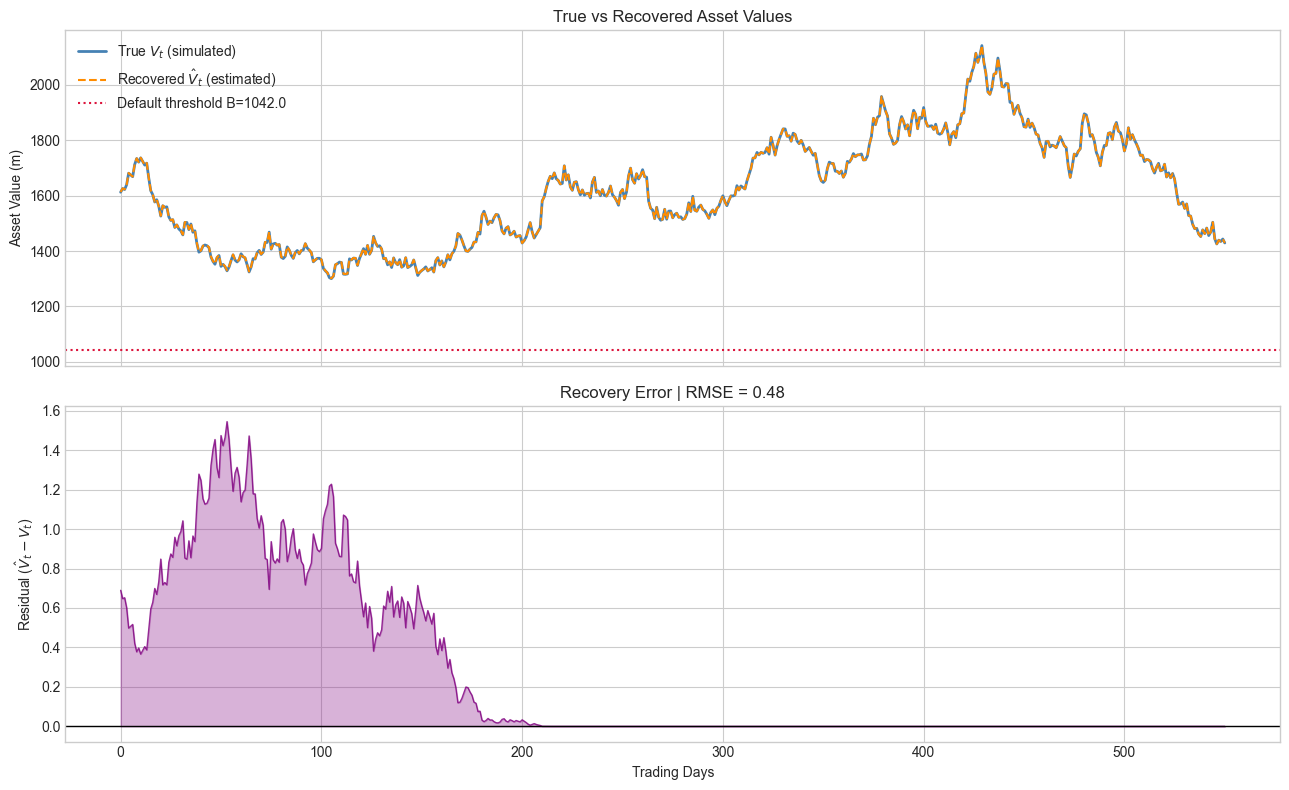

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

days = np.arange(len(V_path))

axes[0].plot(days, V_path, color='steelblue', lw=2, label='True $V_t$ (simulated)')
axes[0].plot(days, V_recovered, color='darkorange', lw=1.5, ls='--', label='Recovered $\\hat{V}_t$ (estimated)')
axes[0].axhline(B, color='crimson', ls=':', lw=1.5, label=f'Default threshold B={B}')
axes[0].set_ylabel('Asset Value (m)')
axes[0].set_title('True vs Recovered Asset Values')
axes[0].legend()

# Residuals
residuals = V_recovered - V_path
axes[1].plot(days, residuals, color='purple', lw=1, alpha=0.8)
axes[1].axhline(0, color='black', lw=1)
axes[1].fill_between(days, residuals, 0, alpha=0.3, color='purple')
axes[1].set_ylabel('Residual ($\\hat{V}_t - V_t$)')
axes[1].set_xlabel('Trading Days')
axes[1].set_title(f'Recovery Error | RMSE = {np.sqrt(np.mean(residuals**2)):.2f}')

plt.tight_layout()
plt.savefig('03_recovery.png', dpi=150, bbox_inches='tight')
plt.show()

## Step 6: Distance to Default and EDF

Once we have $\hat{V}_t$ and $\hat{\sigma}_V$, we compute:

$$DD = \frac{\log(V_0/B)}{\hat{\sigma}_V}$$

$$\text{EDF}_{\text{Merton}} = \Phi(-DD)$$

The full form includes the drift:
$$DD_{\text{full}} = \frac{\log(V_0/B) + (\mu_V - \frac{1}{2}\hat{\sigma}_V^2)}{\hat{\sigma}_V}$$

In [9]:
V0_est    = V_recovered[-1]   # use the last estimated asset value as current
sigma_est = sigma_final

# Estimate mu_V from the recovered asset log-returns
log_ret_V  = np.diff(np.log(V_recovered))
mu_V_est   = np.mean(log_ret_V) * 252 + 0.5 * sigma_est**2  # correct for Ito term

# ─── Simplified DD (lecture slide 15 approximation) ───────────────────────────
DD_simple = np.log(V0_est / B) / sigma_est
EDF_simple = norm.cdf(-DD_simple)

# ─── Full DD (with drift) ─────────────────────────────────────────────────────
DD_full = (np.log(V0_est / B) + (mu_V_est - 0.5 * sigma_est**2)) / sigma_est
EDF_full = norm.cdf(-DD_full)

# ─── True values for comparison ───────────────────────────────────────────────
V0_true_end = V_path[-1]
DD_true     = (np.log(V0_true_end / B) + (mu_V - 0.5 * sigma_V_true**2)) / sigma_V_true
EDF_true    = norm.cdf(-DD_true)

print('─' * 55)
print(f'{"":30s} {"Estimated":>12s} {"True":>10s}')
print('─' * 55)
print(f'{"Asset value V_0":30s} {V0_est:12.1f} {V0_true_end:10.1f}')
print(f'{"Volatility sigma_V":30s} {sigma_est:12.4f} {sigma_V_true:10.4f}')
print(f'{"Drift mu_V (estimated)":30s} {mu_V_est:12.4f} {mu_V:10.4f}')
print(f'{"DD (simplified)":30s} {DD_simple:12.4f} {"n/a":>10s}')
print(f'{"DD (full)":30s} {DD_full:12.4f} {DD_true:10.4f}')
print(f'{"EDF simplified":30s} {EDF_simple:11.2%} {"n/a":>10s}')
print(f'{"EDF full":30s} {EDF_full:11.2%} {EDF_true:9.2%}')
print('─' * 55)

───────────────────────────────────────────────────────
                                  Estimated       True
───────────────────────────────────────────────────────
Asset value V_0                      1429.1     1429.1
Volatility sigma_V                   0.2536     0.2600
Drift mu_V (estimated)              -0.0232     0.0500
DD (simplified)                      1.2457        n/a
DD (full)                            1.0274     1.2773
EDF simplified                      10.64%        n/a
EDF full                            15.21%    10.07%
───────────────────────────────────────────────────────


## Step 7: Sensitivity to Initial Guess

A key practical question: does the algorithm converge to the same solution regardless of initialization?

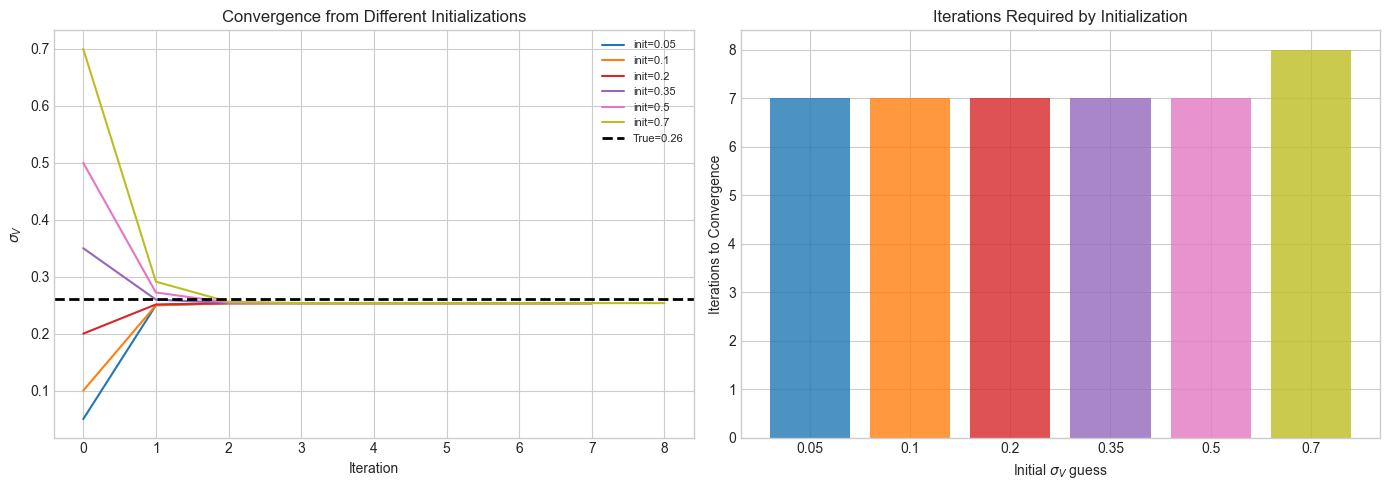

 sigma_init  sigma_final    error  n_iters
       0.05     0.253589 0.006411        7
       0.10     0.253589 0.006411        7
       0.20     0.253589 0.006411        7
       0.35     0.253589 0.006411        7
       0.50     0.253589 0.006411        7
       0.70     0.253589 0.006411        8


In [10]:
sigma_inits = [0.05, 0.10, 0.20, 0.35, 0.50, 0.70]
colors = plt.cm.tab10(np.linspace(0, 0.8, len(sigma_inits)))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

results = []
for i, s0 in enumerate(sigma_inits):
    hist, V_rec = run_iteration(S_observed, taus, B, r, sigma_init=s0,
                                max_iter=300, tol=1e-8, verbose=False)
    results.append({'sigma_init': s0, 'sigma_final': hist[-1],
                    'n_iters': len(hist)-1, 'history': hist})
    axes[0].plot(hist, color=colors[i], lw=1.5, label=f'init={s0}')

axes[0].axhline(sigma_V_true, color='black', ls='--', lw=2, label=f'True={sigma_V_true}')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('$\\sigma_V$')
axes[0].set_title('Convergence from Different Initializations')
axes[0].legend(fontsize=8)

# Summarize convergence
df_results = pd.DataFrame([{k: v for k, v in r.items() if k != 'history'} for r in results])
df_results['error'] = abs(df_results['sigma_final'] - sigma_V_true)

x = np.arange(len(sigma_inits))
axes[1].bar(x, df_results['n_iters'], color=colors, alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'{s}' for s in sigma_inits])
axes[1].set_xlabel('Initial $\\sigma_V$ guess')
axes[1].set_ylabel('Iterations to Convergence')
axes[1].set_title('Iterations Required by Initialization')

plt.tight_layout()
plt.savefig('04_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()

print(df_results[['sigma_init', 'sigma_final', 'error', 'n_iters']].to_string(index=False))

## Step 8: RadioShack Replication

Replicate the lecture example: RadioShack at end of March 2012.

- $B = 1042$m, $V_0 = 1612$m (known from slide)
- $\sigma_V = 0.26$, $DD = 1.67$, $EDF = 4.7\%$

Here we simulate a plausible equity path consistent with these parameters and run the algorithm.

In [11]:
# ─── RadioShack parameters ────────────────────────────────────────────────────
np.random.seed(99)
B_rs     = 1042.0
sigma_rs = 0.26
mu_rs    = 0.03
V0_rs    = 3000.0   # approximate starting value Jan 2010
r_rs     = 0.01
n_rs     = 550      # Jan 2010 to Mar 2012

Z_rs = np.random.standard_normal(n_rs)
V_rs = V0_rs * np.exp(np.cumsum((mu_rs - 0.5*sigma_rs**2)*dt + sigma_rs*np.sqrt(dt)*Z_rs))
V_rs = np.insert(V_rs, 0, V0_rs)

# Scale endpoint to match lecture's V_0=1612 at March 2012
scale = 1612 / V_rs[-1]
V_rs  = V_rs * scale

taus_rs = np.maximum(T - np.arange(len(V_rs)) * dt, 1e-6)
S_rs    = np.array([bs_call(V_rs[i], B_rs, r_rs, sigma_rs, taus_rs[i]) for i in range(len(V_rs))])

# ─── Run iteration ────────────────────────────────────────────────────────────
eq_vol_rs    = np.std(np.diff(np.log(S_rs+1e-8)), ddof=1) * np.sqrt(252)
sigma0_rs    = eq_vol_rs * 0.6
hist_rs, V_hat_rs = run_iteration(S_rs, taus_rs, B_rs, r_rs, sigma0_rs,
                                   max_iter=200, tol=1e-7, verbose=True)

V0_hat   = V_hat_rs[-1]
sig_hat  = hist_rs[-1]
DD_hat   = np.log(V0_hat / B_rs) / sig_hat
EDF_hat  = norm.cdf(-DD_hat)

print(f'\nRadioShack Replication (end of estimation window):')
print(f'  V_0  = {V0_hat:.0f}m  (lecture: 1612)')
print(f'  σ_V  = {sig_hat:.3f}   (lecture: 0.26)')
print(f'  DD   = {DD_hat:.2f}    (lecture: 1.67)')
print(f'  EDF  = {EDF_hat:.1%}   (lecture: 4.7%)')

  Iter   1: sigma_V = 0.451914  |  delta = 6.74e-01
  Iter   2: sigma_V = 0.297922  |  delta = 1.54e-01
  Iter   3: sigma_V = 0.263732  |  delta = 3.42e-02
  Iter   4: sigma_V = 0.256636  |  delta = 7.10e-03
  Iter   5: sigma_V = 0.255201  |  delta = 1.44e-03
  Iter  11: sigma_V = 0.254839  |  delta = 9.43e-08
  >>> Converged at iteration 11 (delta=9.43e-08)

RadioShack Replication (end of estimation window):
  V_0  = 1612m  (lecture: 1612)
  σ_V  = 0.255   (lecture: 0.26)
  DD   = 1.71    (lecture: 1.67)
  EDF  = 4.3%   (lecture: 4.7%)


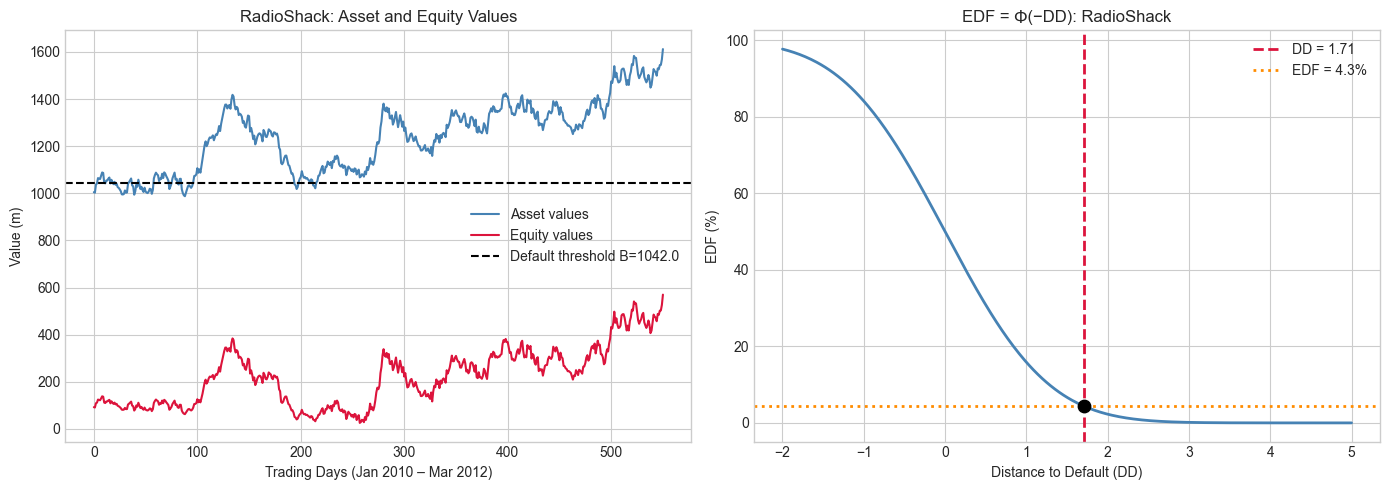

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

days_rs = np.arange(len(V_rs))
axes[0].plot(days_rs, V_rs, color='steelblue', lw=1.5, label='Asset values')
axes[0].plot(days_rs, S_rs, color='crimson', lw=1.5, label='Equity values')
axes[0].axhline(B_rs, color='black', ls='--', lw=1.5, label=f'Default threshold B={B_rs}')
axes[0].set_xlabel('Trading Days (Jan 2010 – Mar 2012)')
axes[0].set_ylabel('Value (m)')
axes[0].set_title('RadioShack: Asset and Equity Values')
axes[0].legend()

# EDF and DD annotation
DD_range = np.linspace(-2, 5, 400)
axes[1].plot(DD_range, norm.cdf(-DD_range) * 100, color='steelblue', lw=2)
axes[1].axvline(DD_hat, color='crimson', ls='--', lw=2,
                label=f'DD = {DD_hat:.2f}')
axes[1].axhline(EDF_hat*100, color='darkorange', ls=':', lw=2,
                label=f'EDF = {EDF_hat:.1%}')
axes[1].scatter([DD_hat], [EDF_hat*100], color='black', zorder=5, s=80)
axes[1].set_xlabel('Distance to Default (DD)')
axes[1].set_ylabel('EDF (%)')
axes[1].set_title('EDF = Φ(−DD): RadioShack')
axes[1].legend()

plt.tight_layout()
plt.savefig('05_radioshack.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

| Step | What we do | Key equation |
|------|-----------|-------------|
| Initialize | Set $\sigma_V^{(0)}$ from equity vol + leverage | $\sigma_V^{(0)} \approx \sigma_S \cdot \frac{S}{S+B}$ |
| Invert BS | Recover $V_t$ at each date | $S_t = \text{BS}(V_t; \sigma_V^{(k)})$ |
| Update $\sigma_V$ | Sample std of asset log-returns | $\sigma_V^{(k+1)} = \text{std}(\Delta\log V_t)\cdot\sqrt{252}$ |
| Convergence | $|\sigma_V^{(k+1)} - \sigma_V^{(k)}| < \epsilon$ | — |
| EDF | Use final $V_0$, $\sigma_V$ | $\text{EDF} = \Phi\left(-\frac{\log(V_0/B)}{\sigma_V}\right)$ |

**Practical caveats:**
- The algorithm converges fast (~10-30 iterations) and is insensitive to initialization
- $\mu_V$ is hard to estimate precisely; KMV simplifies by dropping it from DD
- The normality assumption embedded in $\Phi(\cdot)$ understates tail risk — KMV uses an empirical mapping instead
- Book value of $B$ may not reflect true debt obligations; short-term + 50% long-term is standard